In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("CC GENERAL.csv")
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
data.dtypes

CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object

Missing Values

In [4]:
missing_feature = data.isnull().any()

# grab the missing columns
missing_cols = missing_feature[missing_feature]
missing_cols

CREDIT_LIMIT        True
MINIMUM_PAYMENTS    True
dtype: bool

In [5]:
# apply imputer to handle the missing features - credit_limit and minimum payments
imputer = SimpleImputer()
imputed_data = imputer.fit_transform(data[missing_cols.index])

# remove the missing value
data.drop(columns = missing_cols.index, inplace = True)
data = pd.concat((data, pd.DataFrame(imputed_data, columns = missing_cols.index)), axis = 1)

data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PAYMENTS,PRC_FULL_PAYMENT,TENURE,CREDIT_LIMIT,MINIMUM_PAYMENTS
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,201.802084,0.000000,12,1000.0,139.509787
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,4103.032597,0.222222,12,7000.0,1072.340217
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,622.066742,0.000000,12,7500.0,627.284787
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,0.000000,0.000000,12,7500.0,864.206542
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,678.334763,0.000000,12,1200.0,244.791237


<AxesSubplot:xlabel='Payments', ylabel='Balance'>

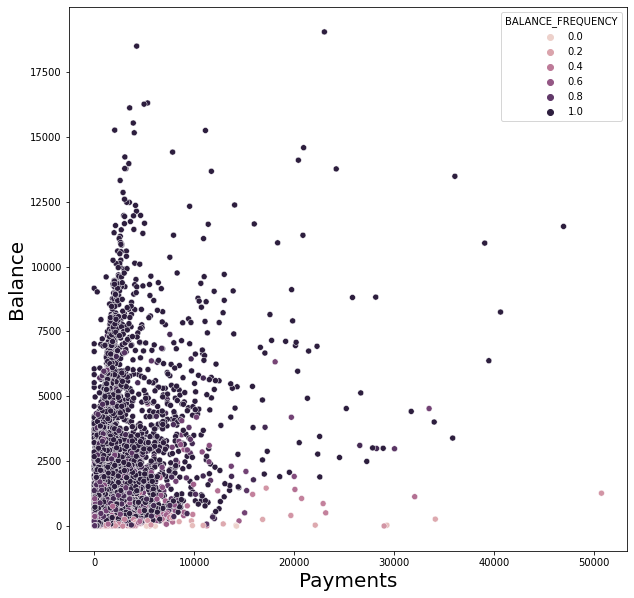

In [6]:
# Visualization of balance
plt.figure(figsize = (10,10))
plt.ylabel("Balance", fontsize = 20)
plt.xlabel("Payments", fontsize = 20)
sns.scatterplot(data = data, x = "PAYMENTS", y = "BALANCE", hue = "BALANCE_FREQUENCY")

Outlier Removal

In [7]:
def outlier_percent(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) |(data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

In [8]:
outlier_pct = outlier_percent(data)
print(outlier_pct)

BALANCE                              7.765363
BALANCE_FREQUENCY                   16.681564
CASH_ADVANCE                        11.508380
CASH_ADVANCE_FREQUENCY               5.865922
CASH_ADVANCE_TRX                     8.983240
CREDIT_LIMIT                         2.770950
CUST_ID                              0.000000
INSTALLMENTS_PURCHASES               9.687151
MINIMUM_PAYMENTS                     8.648045
ONEOFF_PURCHASES                    11.318436
ONEOFF_PURCHASES_FREQUENCY           8.737430
PAYMENTS                             9.027933
PRC_FULL_PAYMENT                    16.469274
PURCHASES                            9.027933
PURCHASES_FREQUENCY                  0.000000
PURCHASES_INSTALLMENTS_FREQUENCY     0.000000
PURCHASES_TRX                        8.558659
TENURE                              15.262570
dtype: float64


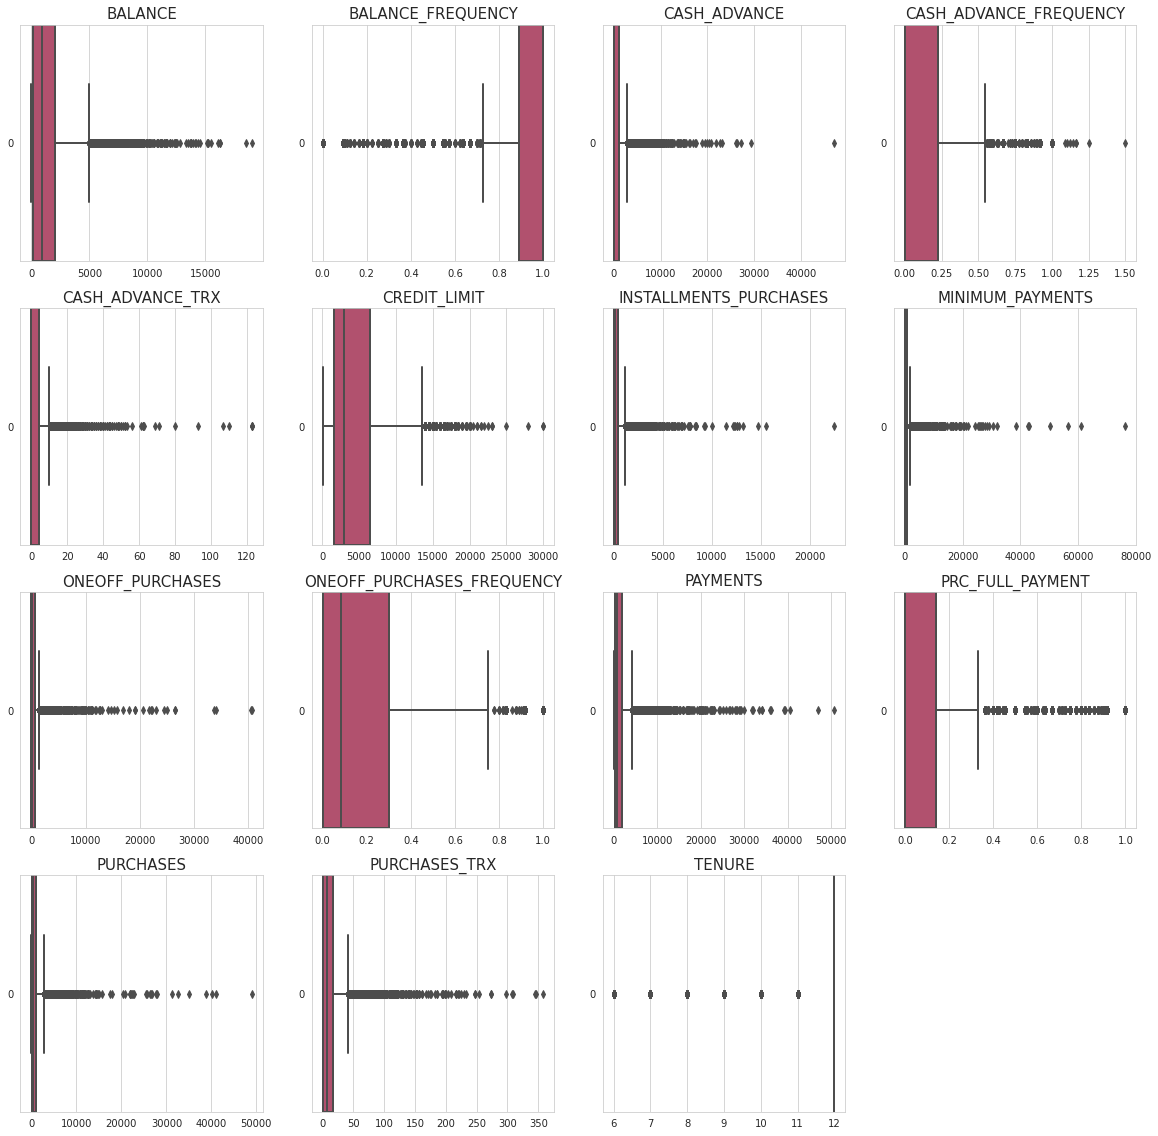

In [9]:
# lets plot out feature that has outlier
outlier_cols = outlier_pct[outlier_pct > 0].index
pnts = [data[cols] for cols in outlier_cols]
plt.figure(figsize = (20,20))
sns.set_style("whitegrid")

for index,values in enumerate(pnts):
    plt.subplot(4,4,index+1)
    plt.title(pnts[index].name, fontsize = 15)
    sns.boxplot(data = values, orient = 'h', palette = 'flare', width = 1, linewidth = 2)
plt.show()

In [10]:
non_categorical_data = data.select_dtypes(exclude = "object")
for column in non_categorical_data.columns:
    non_col_data = data[column]
    
    Q1 = non_col_data.quantile(0.25)
    Q3 = non_col_data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
 
    outliers = ((non_col_data < minimum) |(non_col_data > maximum))
    non_col_data.loc[outliers] = np.nan
    
data.isna().sum()

CUST_ID                                0
BALANCE                              695
BALANCE_FREQUENCY                   1493
PURCHASES                            808
ONEOFF_PURCHASES                    1013
INSTALLMENTS_PURCHASES               867
CASH_ADVANCE                        1030
PURCHASES_FREQUENCY                    0
ONEOFF_PURCHASES_FREQUENCY           782
PURCHASES_INSTALLMENTS_FREQUENCY       0
CASH_ADVANCE_FREQUENCY               525
CASH_ADVANCE_TRX                     804
PURCHASES_TRX                        766
PAYMENTS                             808
PRC_FULL_PAYMENT                    1474
TENURE                              1366
CREDIT_LIMIT                         248
MINIMUM_PAYMENTS                     774
dtype: int64

In [11]:
data.drop(columns = "CUST_ID", inplace = True)

# use KNN imputer to replace the outliers - dont simply drop it instead apply KNN
KNNImputer = KNNImputer()
data = pd.DataFrame(KNNImputer.fit_transform(data), columns = data.columns)

In [12]:
# lets exam the statistic of the data
data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PAYMENTS,PRC_FULL_PAYMENT,TENURE,CREDIT_LIMIT,MINIMUM_PAYMENTS
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.0,8950.000000,8950.000000
mean,1245.384070,0.977885,612.358233,230.291370,224.871677,452.201408,0.490351,0.169303,0.364437,0.105051,1.761341,10.417162,1195.374292,0.031544,12.0,4284.674031,522.313576
std,1286.568848,0.060310,672.463450,344.852278,285.455326,697.396922,0.401371,0.227432,0.397448,0.140601,2.583091,10.780590,1003.011683,0.070106,0.0,3105.158542,451.702096
min,0.000000,0.727273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.0,50.000000,0.019163
25%,128.281915,1.000000,39.550000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,383.276166,0.000000,12.0,1600.000000,170.857654
50%,868.771066,1.000000,360.000000,27.365000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,855.951036,0.000000,12.0,3000.000000,332.523028
75%,1964.201761,1.000000,1023.790000,357.342000,376.515000,830.421087,0.916667,0.272727,0.750000,0.166667,3.000000,17.000000,1878.807169,0.016667,12.0,6272.500000,846.929865
max,4940.113918,1.000000,2711.900000,1443.330000,1170.490000,2784.294727,1.000000,0.750000,1.000000,0.545455,10.000000,41.000000,4177.324826,0.333333,12.0,13600.000000,1900.025531


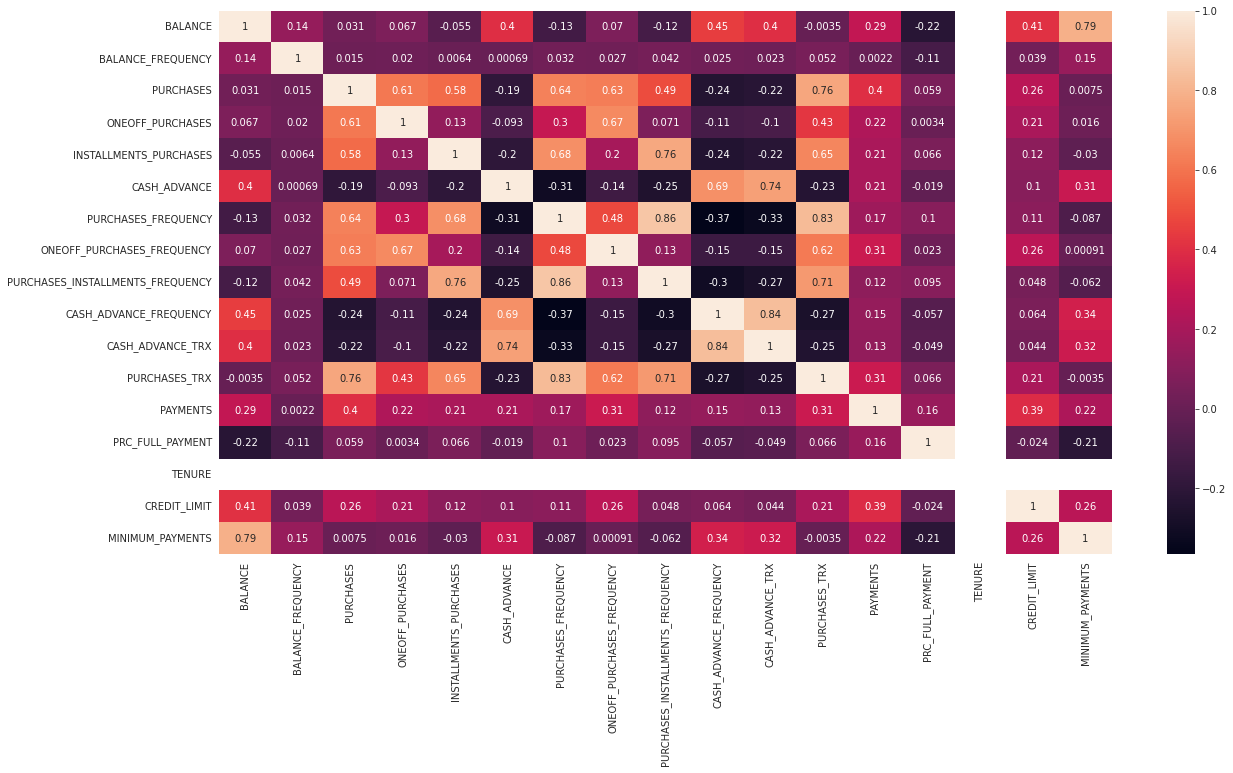

In [13]:
# correlation with each other
correlation = data.corr()
plt.figure(figsize = (20,10))
sns.heatmap(correlation, annot = True)
plt.show()

# we will perform PCA later since there are some features highly correlated to each other

Feature Scaling

In [14]:
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
scaled_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PAYMENTS,PRC_FULL_PAYMENT,TENURE,CREDIT_LIMIT,MINIMUM_PAYMENTS
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.0,8950.000000,8950.000000
mean,0.252096,0.918913,0.225804,0.159556,0.192118,0.162411,0.490351,0.225738,0.364437,0.192594,0.176134,0.254077,0.286158,0.094633,0.0,0.312522,0.274891
std,0.260433,0.221138,0.247968,0.238928,0.243877,0.250475,0.401371,0.303242,0.397448,0.257769,0.258309,0.262941,0.240109,0.210319,0.0,0.229163,0.237737
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.025967,1.000000,0.014584,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.024390,0.091752,0.000000,0.0,0.114391,0.089915
50%,0.175861,1.000000,0.132748,0.018960,0.076037,0.000000,0.500000,0.111111,0.166667,0.000000,0.000000,0.170732,0.204904,0.000000,0.0,0.217712,0.175001
75%,0.397603,1.000000,0.377518,0.247582,0.321673,0.298252,0.916667,0.363636,0.750000,0.305556,0.300000,0.414634,0.449763,0.050000,0.0,0.459225,0.445741
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


PCA

In [15]:
# reserve 90% on variance
pca = PCA(n_components = 0.9, random_state = 10)
pca_data = pca.fit_transform(scaled_data)

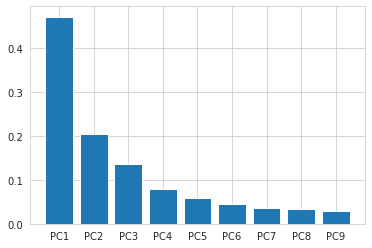

In [16]:
# visualize the explained variance from pca
labels = ["PC{}".format(cnt+1) for cnt in range(pca.n_components_)]
plt.bar(x = labels, height = pca.explained_variance_)
plt.show()

In [17]:
pre_columns = scaled_data.columns
# get back the important feature names and values
post_columns = pre_columns[[np.abs(pca.components_[index]).argmax() for index in range(pca.n_components_)]]

# reconstruct the data
finalized_data = pd.DataFrame(pca_data, columns = post_columns)
finalized_data.head()

,PURCHASES_FREQUENCY,BALANCE,ONEOFF_PURCHASES_FREQUENCY,MINIMUM_PAYMENTS,PAYMENTS,BALANCE_FREQUENCY,PRC_FULL_PAYMENT,CREDIT_LIMIT,ONEOFF_PURCHASES
0,-0.472687,-0.681832,0.092857,0.091859,0.128069,0.524359,-0.032900,-0.080830,-0.068275
1,-0.805469,0.573143,-0.082079,0.076362,0.859822,-0.091954,0.377501,-0.122054,-0.090728
2,0.348891,0.232326,0.774154,-0.250821,-0.289219,0.087284,0.210872,0.377874,-0.041445
3,-0.477653,-0.014666,0.272095,-0.333332,0.014050,0.088065,-0.112119,-0.002321,0.295381
4,-0.568428,-0.497079,0.196090,-0.154970,-0.063152,-0.073431,-0.010042,-0.090419,-0.121675


Elbow Method

In [18]:
k_range = range(1,10)
SSE = []
for k in k_range:
    model = KMeans(n_clusters = k)
    model.fit(finalized_data)
    SSE.append(model.inertia_)

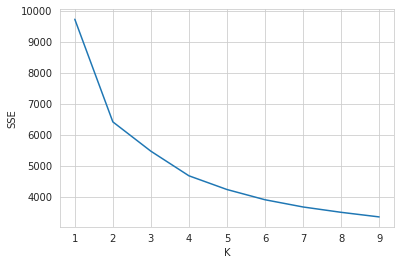

In [19]:
plt.xlabel('K')
plt.ylabel('SSE')
plt.plot(k_range,SSE)

In [20]:
# value with k equal to 2 is the best from elbow method for n_clusters
km_model = KMeans(n_clusters = 2)
km_model.fit(finalized_data)

KMeans(n_clusters=2)

In [21]:
y_pred = km_model.predict(finalized_data)

<AxesSubplot:title={'center':'Cluster Distributions'}, ylabel='label'>

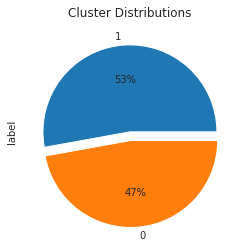

In [22]:
# lets visualize the distribution for each cluster
finalized_data['label'] = y_pred
plt.title("Cluster Distributions")
finalized_data.label.value_counts().plot.pie(autopct='%1.0f%%', explode = [0, 0.1])

Evaluation

The Davis-Bouldin Index is the average similarity between each cluster and the closest cluster. Scores range from 0 and up. 0 indicates better clustering.


The Silhouette Coefficient is a value between -1 and 1. The higher the score, the better. 1 indicates tight clusters, and 0 means overlapping clusters.

In [23]:
print('Davies-Bouldin index = {}'.format(davies_bouldin_score(finalized_data, y_pred)))
print("Silhouette Score = {}".format(silhouette_score(finalized_data, y_pred)))

Davies-Bouldin index = 1.0304561842269326
Silhouette Score = 0.41849823458591334
